## Dataset Details

This dataset is formed from three different data sources used in the **ChatDoctor** project:

### Sources:
- **HealthCareMagic-100k**: 100,000 real conversations between patients and doctors from [HealthCareMagic.com](https://www.healthcaremagic.com/) 
- **iCliniq-10k**: 10,000 real conversations between patients and doctors from [iCliniq.com](https://www.icliniq.com/)
- **GenMedGPT-5k**: 5,000 generated conversations between patients and physicians from ChatGPT and a disease database 
  *(This dataset was not included due to being AI-generated. However, it can be manually added if desired.)*

### Dataset Link:
[Hugging Face Repository](https://huggingface.co/datasets/avaliev/chat_doctor?row=99)

---

## Sample Data:

```json
{
  "instruction": "If you are a doctor, please answer the medical questions based on the patient's description.",
  "input": "I woke up this morning feeling the whole room is spinning when I was sitting down. I went to the bathroom walking unsteadily, as I tried to focus I felt nauseous. I tried to vomit but it wouldn’t come out. After taking Panadol and sleeping for a few hours, I still feel the same. By the way, if I lay down or sit down, my head does not spin—only when I move around do I feel the whole world spinning. And is it normal to have stomach discomfort at the same time? Earlier, after I relieved myself, the spinning lessened, so I am not sure whether it's connected or just a coincidence. Thank you, doc!",
  "output": "Hi, Thank you for posting your query. The most likely cause of your symptoms is **Benign Paroxysmal Positional Vertigo (BPPV)**, a type of peripheral vertigo. The most common symptom is dizziness or giddiness, which worsens with movement. Accompanying nausea and vomiting are common. The condition is due to a problem in the ear and usually improves on its own within a few days. **Betahistine tablets** may help relieve your symptoms. Performing **vestibular rehabilitation** or adaptation exercises can prevent recurrence. An **ENT evaluation** is also recommended. I hope this helps. Best wishes, *Chat Doctor*."
}


In [1]:
!pip install -U langchain langchain-community faiss-cpu datasets sentence-transformers transformers accelerate torch torchvision torchaudio
!pip install bitsandbytes peft
!pip install gradio --quiet


### Huggingface Login using HF Token

In [2]:
import os
os.environ["HUGGINGFACE_TOKEN"] = "yourHFtoken"
!huggingface-cli login --token $HUGGINGFACE_TOKEN


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `mytoken` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `mytoken`


### 1. Exploratory Data Analysis (EDA)

 Loading dataset...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


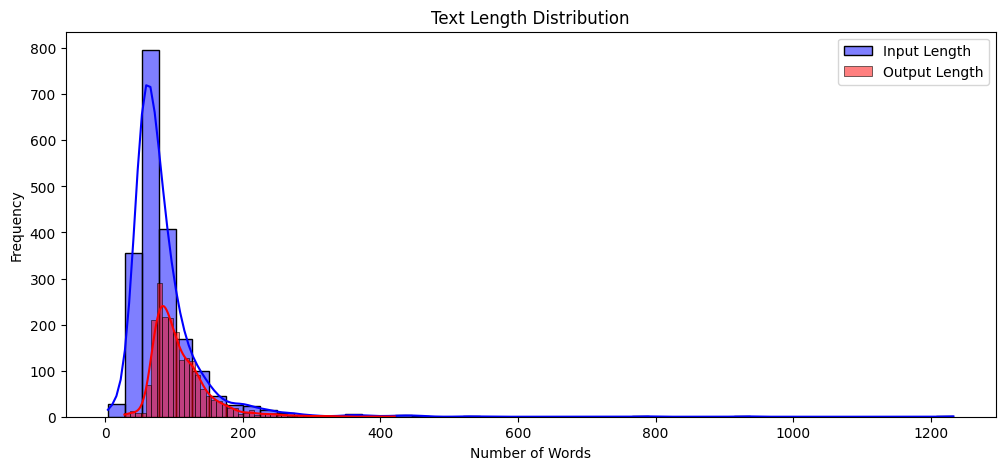

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


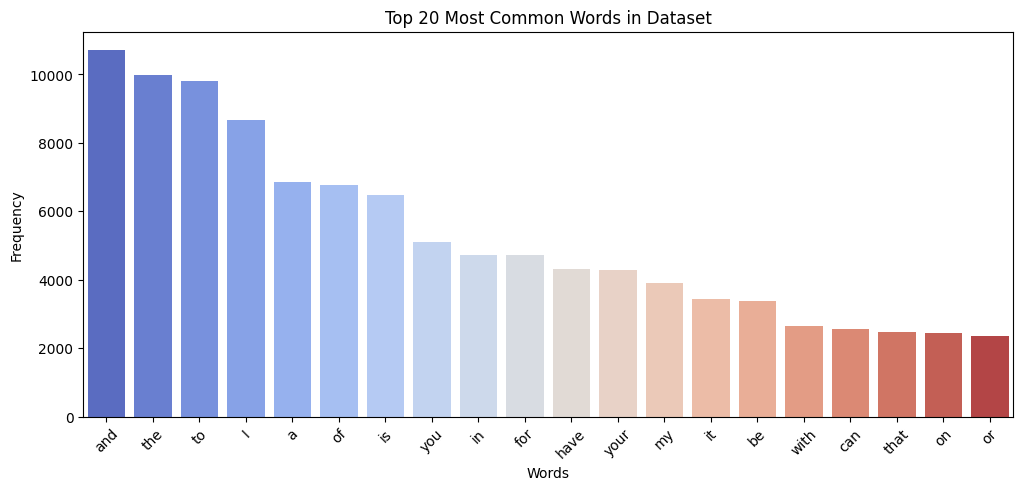

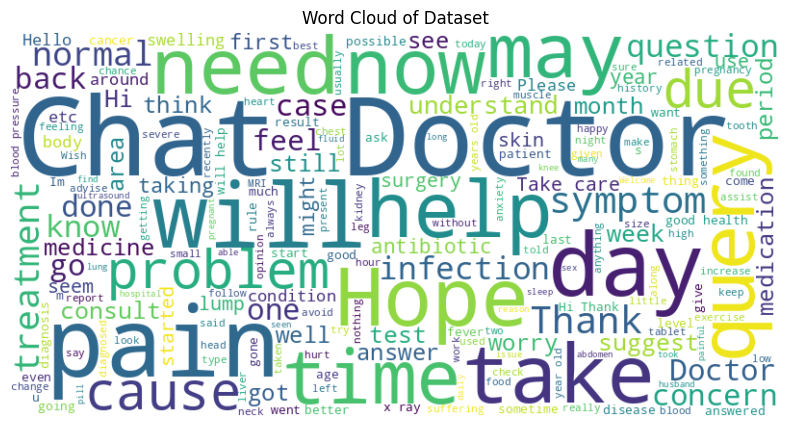


 Generating text embeddings for visualization...


<ipython-input-3-932457cda2fb>:77: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


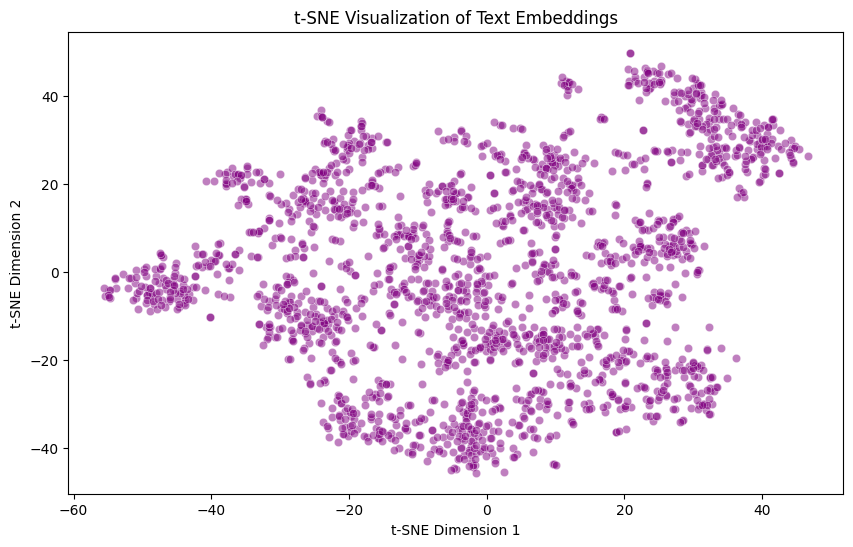


 EDA Completed!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from datasets import load_dataset
import numpy as np
from sklearn.manifold import TSNE
from langchain_community.embeddings import HuggingFaceEmbeddings

def exploratory_data_analysis():

    """
    Performs exploratory data analysis (EDA) on the "Chat Doctor" dataset.

    This function loads the dataset, visualizes text length distributions, 
    analyzes word frequencies, generates a word cloud, and performs t-SNE 
    visualization of text embeddings.

    Steps:
    1. Loads and samples 2,000 rows for efficient visualization.
    2. Computes text length distributions and plots histograms.
    3. Analyzes word frequencies and visualizes the top 20 most common words.
    4. Generates a word cloud from the dataset.
    5. Generates sentence embeddings using a pre-trained MiniLM model.
    6. Applies t-SNE dimensionality reduction to visualize embeddings.

    Returns:
        None: Displays multiple plots and prints EDA completion message.
    """
    
    print(" Loading dataset...")
    dataset = load_dataset("avaliev/chat_doctor")
    df = pd.DataFrame(dataset["train"])

    # Sample Data (Only 2K rows for efficiency in visualization)
    df = df.sample(n=2000, random_state=42)
    df["combined_text"] = df["input"] + " " + df["output"]

    # Word count distributions
    df["input_length"] = df["input"].apply(lambda x: len(str(x).split()))
    df["output_length"] = df["output"].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(12, 5))
    sns.histplot(df["input_length"], bins=50, kde=True, color="blue", label="Input Length")
    sns.histplot(df["output_length"], bins=50, kde=True, color="red", label="Output Length")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.title("Text Length Distribution")
    plt.legend()
    plt.show()

    # Word frequency analysis
    all_words = " ".join(df["combined_text"].astype(str))
    word_counts = Counter(all_words.split())
    common_words = word_counts.most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(words), y=list(counts), palette="coolwarm")
    plt.xticks(rotation=45)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title("Top 20 Most Common Words in Dataset")
    plt.show()

    # Generate a Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Dataset")
    plt.show()

    # Generate Embeddings for Visualization
    print("\n Generating text embeddings for visualization...")
    embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    embeddings = embed_model.embed_documents(df["combined_text"].tolist())

    # Convert list of embeddings to NumPy array for t-SNE
    embeddings_array = np.array(embeddings)

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_results = tsne.fit_transform(embeddings_array)

    # Plot t-SNE results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], alpha=0.5, color="purple")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title("t-SNE Visualization of Text Embeddings")
    plt.show()

    print("\n EDA Completed!")

exploratory_data_analysis()


# Explanation of the t-SNE Plot

## What This t-SNE Plot Represents

- Each **point** represents a **medical QA pair** (question + answer).
- **Closer points** indicate **semantic similarity**, meaning the medical questions or answers are related.
- **Farther apart points** belong to **different topics or clusters**.

---

## Key Observations from the t-SNE Plot

### 1. Presence of Visible Clusters  
- **Certain medical topics naturally group together.**  
- Similar questions (e.g., related to **diabetes, hypertension, or respiratory diseases**) form clusters with similar embeddings.

### 2. Variation in Density  
- **Densely packed regions** → Frequently occurring medical topics in your dataset.  
- **Loosely packed or isolated points** → Rare or outlier topics that don’t fit well with others.

### 3. No Clear Separation of Distinct Groups  
- **t-SNE works well in high-dimensional spaces**, but its projections aren’t always perfectly separable.  
- This suggests a **mix of overlapping medical topics** rather than strictly distinct categories.



### 2. Fine-tuning pre-trained model (t5-small)

In [4]:
import torch
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq

def fine_tune_t5():
    """
    Fine-tunes the T5 model on the ChatDoctor dataset.
    
    Loads the dataset, preprocesses it, tokenizes input-output pairs,
    and fine-tunes the T5 model using the Trainer API. 
    The fine-tuned model is saved to disk.
    
    Returns:
        tuple: (fine-tuned model, Trainer object, tokenizer)
    """
    
    print(" Loading dataset...")
    dataset = load_dataset("avaliev/chat_doctor")

    # Sample only 10,000 records for training
    dataset["train"] = dataset["train"].select(range(10000))  # Limit training data to 10,000 rows

    # Load Tokenizer for T5
    model_name = "t5-small"  # Use a much smaller model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Set padding token
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as PAD token
    print("Pad token set")

    def tokenize_function(examples):
        """ Tokenizes input-output pairs correctly for instruction-based training. """
        
        # Ensure instruction is included
        inputs = [f"Instruction: {instr} Question: {inp}" for instr, inp in zip(examples["instruction"], examples["input"])]
        outputs = [f"{out}" for out in examples["output"]]
    
        # Tokenize inputs and outputs separately
        model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=512)
        labels = tokenizer(outputs, padding="max_length", truncation=True, max_length=512)
    
        # Ensure labels are correctly assigned
        model_inputs["labels"] = labels["input_ids"]
        
        return model_inputs



    print(" Tokenizing dataset...")
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    #  Load T5 Model
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    print(" Model loaded")

    #  Training Arguments
    training_args = TrainingArguments(
        output_dir="./fine_tuned_t5",
        evaluation_strategy="epoch",
        per_device_train_batch_size=8,  #  Larger batch size since T5 is small
        per_device_eval_batch_size=8,
        num_train_epochs=3,  #  More epochs since training is faster
        save_strategy="epoch",
        logging_dir="./logs",
        logging_steps=500,
        report_to="tensorboard"
    )

    print(" Training arguments set")

    #  Data Collator (Handles Padding)
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    #  Trainer Setup
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    print(" Starting fine-tuning...")
    trainer.train()

    return model, trainer, tokenizer


### 3. Track Loss and Accuracy using Tensor Board

In [5]:
import os
from torch.utils.tensorboard import SummaryWriter

def track_training(trainer):
    """
    Logs training and evaluation loss metrics to TensorBoard.

    This function extracts training and evaluation loss from the `trainer` object
    and logs them into TensorBoard for visualization.

    Steps:
    1. Creates a log directory (`./logs`) if it doesn't exist.
    2. Iterates through the `trainer.state.log_history` to extract loss metrics.
    3. Logs `train_loss` and `eval_loss` to TensorBoard.
    4. Closes the TensorBoard writer after logging.

    Args:
        trainer (transformers.Trainer): The Hugging Face `Trainer` instance that stores
            training and evaluation metrics.

    Returns:
        None: Logs the metrics to TensorBoard and prints a confirmation message.

    Example:
        ```python
        track_training(trainer)
        ```
    """
    
    log_dir = "./logs"
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(log_dir)

    for epoch, metrics in enumerate(trainer.state.log_history):
        if "loss" in metrics:
            writer.add_scalar("Loss/train", metrics["loss"], epoch)
        if "eval_loss" in metrics:
            writer.add_scalar("Loss/eval", metrics["eval_loss"], epoch)

    writer.close()
    print("Training progress logged in TensorBoard!")



### 4. Evaluate the fine-tuned model test data

In [6]:
import numpy as np

def evaluate_model(model, trainer, tokenizer, dataset):

    """
    Evaluates the fine-tuned T5 model on a test dataset.

    This function tokenizes the dataset, prepares the `decoder_input_ids`
    required for T5 models, and evaluates the model using the Hugging Face `Trainer`.

    Steps:
    1. Preprocesses input and output pairs into a structured format.
    2. Tokenizes the dataset with padding and truncation.
    3. Adds `decoder_input_ids` to match T5's expected input format.
    4. Uses the `Trainer` to evaluate the model on the test set.
    5. Prints and returns evaluation metrics.

    Args:
        model (transformers.PreTrainedModel): The fine-tuned model to be evaluated.
        trainer (transformers.Trainer): The Hugging Face Trainer instance for evaluation.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the model.
        dataset (datasets.DatasetDict): Dataset containing a "test" split.

    Returns:
        dict: A dictionary containing evaluation metrics such as `eval_loss`.

    Example:
        ```python
        dataset = load_dataset("avaliev/chat_doctor")
        metrics = evaluate_model(model, trainer, tokenizer, dataset)
        ```
    """
    
    print(" Evaluating the fine-tuned model...")

    # Create `decoder_input_ids` dynamically
    def preprocess_function(examples):
        combined_texts = [f"question: {inp} answer: {out}" for inp, out in zip(examples["input"], examples["output"])]
        tokenized = tokenizer(combined_texts, padding="max_length", truncation=True, max_length=512)

        # Add `decoder_input_ids` to match T5 structure
        tokenized["labels"] = tokenized["input_ids"].copy()
        tokenized["decoder_input_ids"] = tokenizer(["answer: " + out for out in examples["output"]], 
                                                   padding="max_length", truncation=True, max_length=512)["input_ids"]
        
        return tokenized

    # Apply Tokenization on the Test Set
    tokenized_test = dataset["test"].map(preprocess_function, batched=True)

    # Evaluate Model
    metrics = trainer.evaluate(tokenized_test)
    print(f" Evaluation Metrics: {metrics}")

    return metrics


### 5. Make Prediction

In [7]:
def generate_predictions(model, tokenizer, input_text):
    """
    Generates a medical response using the fine-tuned T5 model.
    
    Args:
        model (AutoModelForSeq2SeqLM): The fine-tuned T5 model.
        tokenizer (AutoTokenizer): The tokenizer corresponding to the model.
        input_text (str): The medical question provided by the user.
    
    Returns:
        str: The generated response from the model.
    """

    # Structured input format
    formatted_input = f"Instruction: If you are a doctor, please answer the medical questions based on the patient's description.\n\nQuestion: {input_text}\n\nAnswer:"

    # Tokenize input
    inputs = tokenizer(formatted_input, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    # Generate response with better control
    output_ids = model.generate(
        **inputs,
        max_length=100,  #  Increased length to prevent truncation
        min_length=30,  #  Ensures full response
        num_beams=6,  # Increased for better diversity
        no_repeat_ngram_size=4,  #  Prevents repeating 4-word phrases
        repetition_penalty=2.3,  # Stricter repetition control
        early_stopping=True,  #  Stops at natural end
        temperature=0.5,  #  Slight randomness for better flow
        top_k=40,  #  Keeps diversity but prevents random noise
        top_p=0.85,  # Nucleus sampling for more controlled output
        length_penalty=0.9  # Avoids cutting off responses too soon
    )

    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    return response


### Deploy the model as a RAG application

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
import pandas as pd
from datasets import load_dataset
import torch

def deploy_fine_tuned_model():
    """
    Deploys the fine-tuned T5 model as a RAG-based chatbot using FAISS for document retrieval.

    This function:
    - Loads a fine-tuned T5 model and tokenizer.
    - Loads the `chat_doctor` dataset and preprocesses it.
    - Generates text embeddings using SentenceTransformers.
    - Stores embeddings in a FAISS vector store for retrieval.
    - Builds a retrieval-based chatbot that fetches relevant documents and generates answers.

    Returns:
        function: A `medical_qa_bot(question)` function that takes user input, retrieves context, and generates responses.

    Example:
        ```python
        chatbot = deploy_fine_tuned_model()
        response = chatbot("What are the symptoms of diabetes?")
        print(response)
        ```
    """
    
    print(" Loading fine-tuned model for deployment...")
    model_path = "/kaggle/working/fine_tuned_t5/checkpoint-3750"  

    # Load Fine-Tuned Model & Tokenizer
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Model and tokenizer loaded!")

    # Reload dataset (Fixes `df` error)
    dataset = load_dataset("avaliev/chat_doctor")
    df = pd.DataFrame(dataset["train"])

    #  Combine input and output for FAISS
    df["combined_text"] = df["input"] + " " + df["output"]

    # Load FAISS Embeddings
    print(" Loading FAISS Embeddings...")
    embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    #  Compute embeddings for FAISS
    print(" Computing embeddings for FAISS...")
    vectorstore = FAISS.from_texts(df["combined_text"].tolist(), embed_model)

    # Save & Load FAISS Index
    vectorstore.save_local("faiss_index")
    print(" FAISS index saved successfully!")

    print(" Loading FAISS Vector Store...")
    vectorstore = FAISS.load_local("faiss_index", embed_model, allow_dangerous_deserialization=True)

    retriever = vectorstore.as_retriever()

    # Define Custom Medical QA Function
    def medical_qa_bot(question):
        """
        Retrieves relevant documents from FAISS and generates an answer using the fine-tuned model.

        Args:
            question (str): The user's medical query.

        Returns:
            str: The AI-generated medical response.

        Example:
            ```python
            response = medical_qa_bot("What are the symptoms of diabetes?")
            print(response)
            ```
        """
        # Retrieve similar text from FAISS
        docs = retriever.get_relevant_documents(question)
        context = " ".join([doc.page_content for doc in docs])

        # Format input for the model
        formatted_question = f"{context}\n\nQuestion: {question}\n\nAnswer:"

        # Generate response using fine-tuned model
        response = generate_predictions(model, tokenizer, formatted_question)

        return response

    print(" Model deployed successfully! Ready to chat.")
    return medical_qa_bot


In [9]:
# Phase 1: Fine-Tune Model
# model, trainer, tokenizer = fine_tune_t5()

# # Phase 2: Track Training
# track_training(trainer)

# # # Phase 3: Evaluate Model
# evaluate_model(model, trainer, tokenizer, load_dataset("avaliev/chat_doctor"))

# # Phase 4: Make Predictions
# generate_predictions(model, tokenizer, "What are the symptoms of diabetes?")

# # Phase 5: Deploy the Model
# qa_bot = deploy_fine_tuned_model()


## Execution (Function calls)
---
### Phase 1: 
- Fine-Tuning the Model.
- Saving and downloading the fine-tuned version.

In [10]:
# Phase 1: Fine-Tune Model
model, trainer, tokenizer = fine_tune_t5()

 Loading dataset...
Pad token set
 Tokenizing dataset...


Map:   0%|          | 0/11949 [00:00<?, ? examples/s]

 Model loaded
 Training arguments set
 Starting fine-tuning...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-8fdaf52d4b30>:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,1.165600,1.060721
2,1.111500,1.032699
3,1.085900,1.025039


### Download the fine-tuned model to save it locally.

In [11]:
# Download the saved model
import shutil
from IPython.display import FileLink

# Create a zip archive of the fine-tuned model
shutil.make_archive('fine_tuned_t5_checkpoint', 'zip', '/kaggle/working/fine_tuned_t5/checkpoint-3750')

# Generate download link
FileLink(r'fine_tuned_t5_checkpoint.zip')



/kaggle/working/fine_tuned_t5_checkpoint.zip

---
### Phase 2: 
- Track Training using Tensor Board.
- Evaluate model on Test Dataset
- Plot Graph Training and Evaluation Loss Curve
- Make Prediction
-[Sample Questions for Prediction: "What are the symptoms of diabetes?", "How can I manage high blood pressure?", "What are the treatments for asthma?"]

In [12]:
# Track Training 
track_training(trainer)

Training progress logged in TensorBoard!


In [13]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs --host 0.0.0.0 --port 6006

<IPython.core.display.Javascript object>

In [14]:
# Model Evaluation
evaluate_model(model, trainer, tokenizer, load_dataset("avaliev/chat_doctor"))

 Evaluating the fine-tuned model...


Map:   0%|          | 0/11949 [00:00<?, ? examples/s]

 Evaluation Metrics: {'eval_loss': 0.6810392737388611, 'eval_runtime': 208.3295, 'eval_samples_per_second': 57.356, 'eval_steps_per_second': 7.171, 'epoch': 3.0}


{'eval_loss': 0.6810392737388611,
 'eval_runtime': 208.3295,
 'eval_samples_per_second': 57.356,
 'eval_steps_per_second': 7.171,
 'epoch': 3.0}

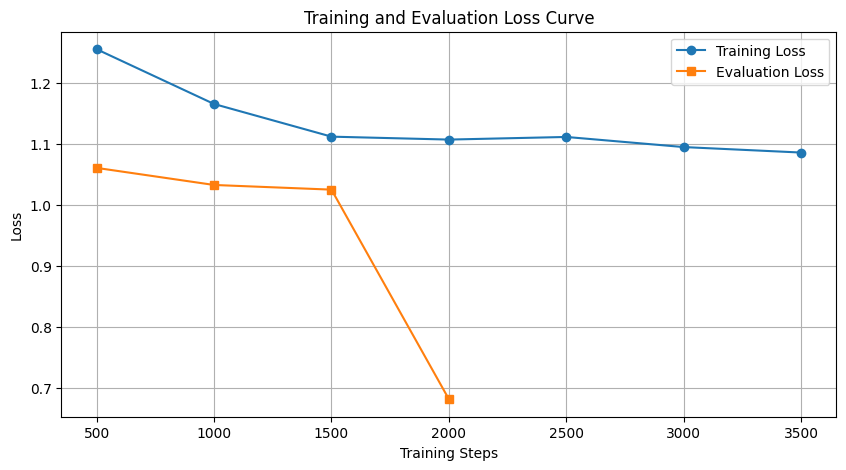

In [15]:
# Plotting Graph (Training Loss, Evaluation Loss)
import matplotlib.pyplot as plt

def plot_training_metrics(trainer):
    """
    Plots training loss and evaluation loss from Trainer's log history.
    """
    # Extract loss values from trainer logs
    log_history = trainer.state.log_history

    # Separate training loss and evaluation loss
    steps = []
    train_losses = []
    eval_losses = []

    for entry in log_history:
        if "loss" in entry:
            train_losses.append(entry["loss"])
            steps.append(entry["step"])
        if "eval_loss" in entry:
            eval_losses.append(entry["eval_loss"])

    # Plot Training and Evaluation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss", marker="o")
    if eval_losses:
        plt.plot(steps[:len(eval_losses)], eval_losses, label="Evaluation Loss", marker="s")

    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_metrics(trainer)


In [16]:
# Make Predictions
generate_predictions(model, tokenizer, "What are the symptoms of diabetes?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.85` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:650: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


'Hi, Welcome to Chat Doctor forum. I have gone through your query and can understand your concern. If you are having diabetes then you should consult a doctor for the diagnosis of diabetes. It is important that you do not need to worry about diabetes. This will help you to prevent diabetes. Hope this answers your query. Wishing you good health.'

---
### Phase 3: 
- Deploy the fine-tuned model as a RAG application.
- Gradio Interface as a front-end, for Client Interaction

In [17]:
# Deploy the Model
qa_bot = deploy_fine_tuned_model()

 Loading fine-tuned model for deployment...
Model and tokenizer loaded!
 Loading FAISS Embeddings...
 Computing embeddings for FAISS...
 FAISS index saved successfully!
 Loading FAISS Vector Store...
 Model deployed successfully! Ready to chat.


### Gradio interface

In [18]:
import gradio as gr

def gradio_interface():
    """
    Launches a Gradio-based interface for the Medical QA Bot.

    This function initializes and deploys a fine-tuned T5-based chatbot using Gradio.
    It allows users to input medical-related questions and receive AI-generated responses.

    The function performs the following steps:
    1. Deploys the fine-tuned model via `deploy_fine_tuned_model()`.
    2. Defines a chat function that takes user input and retrieves model responses.
    3. Creates an interactive Gradio UI with a text input and output box.
    4. Launches the Gradio interface with a public link.

    Returns:
        None: The function launches the Gradio interface and does not return a value.
    
    Example:
        To start the chatbot UI, simply call:
        
        >>> gradio_interface()
        
        This will display an interactive web UI where users can input medical queries.
    """

    # Deploy the fine-tuned model (loads the `qa_bot` function)
    qa_bot = deploy_fine_tuned_model()

    # Define Gradio function to interact with the bot
    def chat_function(user_input):
        """
        Generates a response from the fine-tuned model based on user input.

        Args:
            user_input (str): The medical question entered by the user.

        Returns:
            str: The chatbot-generated response.
        """
        response = qa_bot(user_input)
        return response

    # Create Gradio UI
    interface = gr.Interface(
        fn=chat_function,  # Function to call
        inputs=gr.Textbox(lines=2, placeholder="Enter your medical question..."),
        outputs=gr.Textbox(),
        title=" Medical ChatBot (T5 Fine-Tuned)",
        description="Ask medical-related questions and get answers from the fine-tuned T5 model!",
        theme="default"
    )

    # Launch the UI
    interface.launch(share=True)  # Use `share=True` to get a public link
# start the Gradio UI
gradio_interface()


 Loading fine-tuned model for deployment...
Model and tokenizer loaded!
 Loading FAISS Embeddings...
 Computing embeddings for FAISS...
 FAISS index saved successfully!
 Loading FAISS Vector Store...
 Model deployed successfully! Ready to chat.
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://29cf35526c11140897.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Individual Learning:

### Chaoyu Learning -
---

### Eric's Learning -
---

### Moossa's Learning
---

#### Understanding Resource & Time Constraints
- Large models like **Mistral-7B-OpenOrca** require significant resources.  
- Training **just 1,000 samples for 1 epoch with QLoRA optimization** took over **3 hours**.  
- Could not complete training due to high resource demands, leading to a switch to **T5-small** for efficiency.

#### Importance of Exploratory Data Analysis (EDA)
- EDA is crucial before model fine-tuning to understand the dataset.  
- Key insights like **context length** directly impact model learning.  
- If text length exceeds the model's limit, **important information may be lost**.  
- Different models have different **context window sizes**, so selection matters.

#### Impact of Hyperparameter Tuning
- Hyperparameter tuning plays a major role in:
  - Training time  
  - Model convergence  
  - Performance improvement  
- Small changes can significantly alter computation time and results.

#### Implementing a RAG-Based Solution with LangChain
- **LangChain** provides a structured approach to building RAG applications.  
- Explored:
  - **Vector Databases**
  - **Similarity Search**
  - **Retrieval Algorithms**  
- Understood how RAG helps **retrieve relevant context** before generating responses.

#### Interactive UI Development
- Implemented a **simple front-end** using **Gradio**, enabling an interactive chatbot experience.  
- **Gradio** makes it easy to deploy **LLM-based applications** without heavy frontend development.

#### Key Takeaways on Resource Optimization
- **Computational resources are the biggest constraint** in model training.  
- Techniques like **LoRA, QLoRA (4-bit optimization)** help reduce memory consumption while maintaining efficiency.  
- **Choosing the right model & training approach** depends on the specific **use case** and available compute.

#### Utilizing Free GPU Resources
- Used **Google Colab & Kaggle** for free GPU access.  
- **Preferred Kaggle** over Colab due to **session timeout issues** in Colab.  

#### Model Saving & Reusability
- **Saving the fine-tuned model** is crucial for:
  - Avoiding redundant training
  - Optimizing resource utilization
  - Deploying models efficiently without re-training

#### RAG & AI Hallucination
- **RAG helps LLMs generate more context-specific responses**, reducing hallucination.  
- However, **RAG alone cannot fully eliminate AI hallucination**—further refinements and filtering mechanisms are needed.


### Pranav's Learning -
---

### Sam's Learning -
---

### Shrey's Learning -
---

---
---
# Medical QA Bot: Fine-Tuning & RAG Implementation

## Project Summary
This project involves building a **Medical Question-Answering (QA) Bot** using **Retrieval-Augmented Generation (RAG)** and fine-tuning **T5-small** on the **ChatDoctor dataset**. The workflow includes **data exploration, model fine-tuning, evaluation, deployment, and interactive UI implementation** using Gradio.

### Key Steps & Implementation
1. **Exploratory Data Analysis (EDA)**
   - Analyzed dataset statistics, text length distributions, and most frequent words.
   - Applied **t-SNE visualization** on embeddings to understand document clustering.

2. **Fine-Tuning the Model**
   - Initially attempted fine-tuning **Mistral-7B-OpenOrca**, but due to **high resource demands**, switched to **T5-small**.
   - Applied **QLoRA (4-bit optimization)** but still encountered resource constraints.
   - Used **Google Colab & Kaggle GPUs**, preferring Kaggle due to **Colab session timeouts**.
   - Performed hyperparameter tuning to optimize training efficiency.

3. **Model Evaluation & Tracking**
   - Logged training loss and evaluation metrics using **TensorBoard**.
   - Applied **custom loss tracking** to monitor performance improvements.
   - Conducted inference tests to validate model responses.

4. **RAG-Based Retrieval System**
   - Implemented **FAISS** for storing and retrieving **document embeddings**.
   - Used **LangChain** to structure the **retrieval-augmented pipeline**.
   - Integrated **Hugging Face Embeddings (MiniLM)** for efficient similarity search.

5. **Interactive Deployment Using Gradio**
   - Built a **simple yet effective UI** for querying the medical chatbot.
   - Deployed the fine-tuned model with **Gradio-based web interface**.
   - Ensured that queries were processed in real-time using **LangChain RetrievalQA**.

---

## Results & Insights
- Fine-tuning a large model like Mistral-7B was infeasible due to resource constraints, necessitating a shift to **T5-small**.  
- Hyperparameter tuning significantly affects training time and performance, making **batch size, learning rate, and context length** crucial factors.  
- Retrieval-Augmented Generation (RAG) improves response relevance by incorporating contextual information from similar retrieved queries.  
- Gradio provides an effective and lightweight UI solution for real-time inference, making chatbot deployment seamless.  
- RAG helps reduce hallucination, but does not eliminate it completely, requiring further filtering and fine-tuning.

---

## Challenges Faced
- **High resource demand**: Training large models like Mistral-7B required **high-end GPUs**, making fine-tuning impractical.
- **Long training times**: Even with **QLoRA**, training remained **resource-intensive**.
- **Response repetition issues**: Initially, model outputs contained **repetitive sentences**, requiring **beam search tuning**.
- **Session timeouts**: **Colab frequently disconnected**, leading to preference for **Kaggle's persistent sessions**.

---

## Future Work
### Optimize Fine-Tuning Strategies
- Use **LoRA adapters** to fine-tune larger models with fewer resources.  
- Explore **parameter-efficient fine-tuning (PEFT)** methods.  
- Use **mixed-precision training (FP16/BF16)** for reduced memory consumption.  

### Enhance RAG System
- Implement **more advanced similarity search** techniques such as **hybrid retrieval (BM25 + dense embeddings)**.  
- Use **context filtering** to refine retrieved documents for more accurate generation.  
- Experiment with **chunk-based retrieval** to prevent exceeding model context length.  

### Improve Model Interpretability
- Integrate **SHAP or LIME** for explainability in AI-generated medical responses.  
- Track **confidence scores** to **flag uncertain predictions** for human review.  

### Expand UI & Deployment
- Convert **Gradio interface into a full-stack web app** with **Flask/FastAPI backend**.  
- Deploy the chatbot on **Hugging Face Spaces or AWS Lambda** for wider accessibility.  
- Implement **voice input** and **speech-to-text capabilities** for interactive Q&A.  

---

## Final Thoughts
This project demonstrated the feasibility of **fine-tuning T5-small for medical question answering** while leveraging **RAG-based retrieval for contextual enhancement**. While the chatbot performs well, **AI hallucination and response accuracy remain key challenges** that future work will focus on improving. 

By optimizing training efficiency, enhancing retrieval mechanisms, and refining model deployment strategies, this project can be expanded into a **fully functional AI medical assistant** capable of handling **real-world use cases**.
